In [1]:
from einops import rearrange
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Pad
import matplotlib.pyplot as plt

In [2]:
fashion_data_train = torchvision.datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transforms.Compose([Pad([2,2,2,2]), ToTensor()]))
fashion_data_test = torchvision.datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transforms.Compose([Pad([2,2,2,2]), ToTensor()]))

In [3]:
dl_train = torch.utils.data.DataLoader(fashion_data_train, batch_size=64, shuffle=True, num_workers=4)
dl_test = torch.utils.data.DataLoader(fashion_data_test, batch_size=128, shuffle=True, num_workers=4)

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [5]:
x, y = next(iter(dl_train))
x.shape

torch.Size([64, 1, 32, 32])

Trouser


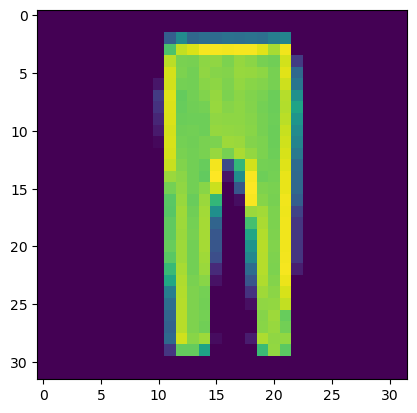

In [6]:
print(labels_map[y[0].item()])
plt.imshow(x[0].squeeze())

In [7]:
n_patch = 16
nh = nw = int(n_patch**.5)
print(nh, nw)
#rearrange(x, 'b c (nh ph) (nw pw) -> b (nh nw) (c ph pw)', nh=nh, nw=nw)
x1 = rearrange(x, 'b c (nh ph) (nw pw) -> b nh nw (c ph pw)', nh=nh, nw=nw)
x2 = rearrange(x1, 'b nh nw d -> b (nh nw) d', nh=nh, nw=nw).shape
x2

4 4


torch.Size([64, 16, 64])

In [8]:
device = "cuda"
lr=1e-3

In [9]:
class Transformer_dummy(nn.Module):
    def __init__(self, dim, mlp_hidden_dim=4098, attention_heads=8, depth=2 ):
        super().__init__()

    def forward(self, x):
        return x
        
class MyViT(nn.Module):
    def __init__(self, image_size, patch_size, dim, n_classes = len(labels_map), device = device, depth=5):
        super().__init__()
        self.image_size = image_size #height == width
        self.patch_size = patch_size #height == width
        self.dim = dim # dim of latent space for each patch
        self.n_classes = n_classes
        
        self.nh = self.nw = image_size // patch_size 
        self.n_patches = self.nh * self.nw # number or patches, i.e. NLP's seq len

        self.layernorm1 = nn.LayerNorm(self.patch_size**2)
        self.ln = nn.Linear(self.patch_size**2, dim)
        self.layernorm2 = nn.LayerNorm(dim)
        self.pos_encoding = nn.Embedding(self.n_patches, self.dim)
        self.transformer = Transformer(dim=self.dim, depth=depth)


        #self.proj = nn.Linear(self.dim * self.n_patches, self.n_classes)
        self.proj = nn.Linear(self.dim, self.n_classes)

    def forward(self, x):
        # rearrange 'b c (nh ph) (nw pw) -> b nh nw (c ph pw)'
        x = rearrange(x, 'b c (nh ph) (nw pw) -> b nh nw (c ph pw)', nh=self.nh, nw=self.nw)
        # rearrange 'b nh nw d -> b (nh nw) d'
        x = rearrange(x, 'b nh nw d -> b (nh nw) d')

        
        x = self.layernorm1(x)        
        x = self.ln(x) #(b n_patches patch_size*patch_size) -> (b n_patches dim)
        x = self.layernorm2(x)

        pos = self.pos_encoding(torch.arange(0, self.n_patches).to(device))

        x = x + pos
        
        x = self.transformer(x)

        #x = self.proj(x.view(x.shape[0],-1))
        x = self.proj(x.mean(dim=1))

        return x
        

In [10]:
#model = MyViT(image_size=32, patch_size=8, dim=1024).to(device)

In [11]:
#lossFunc = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#lr_scheduler = 

def train(epoches):
    for _ in range(epoches):
        step = 0
        losses = 0
        model.train()
        for data_train, label_train in dl_train:
            data_train = (data_train-0.5).to(device)
            label_train = label_train.to(device)
            logits = model(data_train)
            loss = lossFunc(logits, label_train)
            loss.backward()
            with torch.no_grad():
                optimizer.step()
                optimizer.zero_grad()
        
            step+=1
            if step % 100 == 0:
                print(f"loss is {losses/100}")
                losses = 0
            losses += loss.item()

        model.eval()
        with torch.no_grad():
            data_test, label_test = next(iter(dl_test))
            data_test = (data_test-0.5).to(device)
            label_test = label_test.to(device)
            logits = model(data_test)
            accuracy = (logits.argmax(dim=-1) == label_test).sum()/label_test.shape[0]
            print(f"accuracy is {accuracy}")
        
    

In [12]:
len(dl_test)

79

In [13]:
class MLPBlock(nn.Module):
    def __init__(self, dim, mlp_hidden_dim=4096, dropout=0.):
        super().__init__()
        self.layernorm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.proj1 = nn.Linear(dim, mlp_hidden_dim)
        self.proj2 = nn.Linear(mlp_hidden_dim, dim)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.layernorm(x)

        x = self.proj1(x)
        x = self.activation(x)
        x = self.dropout(x)        
        x = self.proj2(x)
        x = self.dropout2(x)
        
        return x
        
class AttentionBlock(nn.Module):
    def __init__(self, dim, attention_heads = 8, depth=2, dropout=0.):
        super().__init__()
        self.dim = dim
        self.attention_heads = attention_heads
        
        self.layernorm = nn.LayerNorm(dim)
        self.proj = nn.Linear(dim, 3*dim)
        self.attention = nn.Softmax(dim = -1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layernorm(x)
        q,k,v = self.proj(x).chunk(3, dim=-1)
        
        # rearrange to b, num_heads, seq, head_size
        q = rearrange(q, 'b s (nh hs) -> b nh s hs', nh = self.attention_heads)
        k = rearrange(k, 'b s (nh hs) -> b nh hs s', nh = self.attention_heads)
        v = rearrange(v, 'b s (nh hs) -> b nh s hs', nh = self.attention_heads)

        # attention q@kT
        x = q@k

        # scale
        x = x * (k.shape[-1] ** -0.5)

        # attention mask not needed
        #x = x.mask_fill(torch.ones((1,1, k.shape[-1], k.shape[-1])).tril())

        # attention softmax
        x = self.attention(x)

        # drop out
        x = self.drop(x)

        # attention q@kT@v
        x = x@v

        # rearrange to b, seq, (num_heads, head_size)
        x = rearrange(x, 'b nh s hs -> b s (nh hs)', nh = self.attention_heads)

        return x
        

class Transformer(nn.Module):
    def __init__(self, dim, mlp_hidden_dim=4098, attention_heads=8, depth=5 ):
        super().__init__()
        self.layernorm = nn.LayerNorm(dim)
        #self.net = nn.Sequential(*([AttentionBlock(dim=dim), MLPBlock(dim=dim)] * depth))
        #self.net = nn.Sequential(*([MLPBlock(dim=dim)] * depth))
        self.net = nn.ModuleList([AttentionBlock(dim=dim), MLPBlock(dim=dim)] * depth)
        

    def forward(self, x):
        for m in self.net:
            x = x + m(x)
        x = self.layernorm(x)
        return x

In [14]:
model = MyViT(image_size=32, patch_size=4, dim=256, depth=2).to(device)
lossFunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
train(epoches = 10)

loss is 1.1556322646141053
loss is 0.6365352895855904
loss is 0.5412473030388355
loss is 0.5158590659499168
loss is 0.4675754211843014
loss is 0.447547090947628
loss is 0.45171445965766904
loss is 0.39996898457407953
loss is 0.400007429420948
accuracy is 0.8515625
loss is 0.3653336361050606
loss is 0.3598775805532932
loss is 0.3701637613773346
loss is 0.373639519661665
loss is 0.35503422901034354
loss is 0.36261730805039405
loss is 0.3571916051208973
loss is 0.35216414242982863
loss is 0.34049608260393144
accuracy is 0.875
loss is 0.30841057196259497
loss is 0.29692624680697915
loss is 0.3094658311456442
loss is 0.32230329111218453
loss is 0.3086127416789532
loss is 0.31288267724215985
loss is 0.3075242643803358
loss is 0.3006883884221315
loss is 0.301412169188261
accuracy is 0.8515625
loss is 0.259475910961628
loss is 0.2638974793255329
loss is 0.26720745969563725
loss is 0.266714890897274
loss is 0.28658212646842
loss is 0.28004994966089725
loss is 0.2748061515390873
loss is 0.285858

In [18]:
torch.save(model, "vit01.pt")